In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D, Dropout

# ----------------------
# 1. Veri Hazırlama
# ----------------------
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Gereksiz kolonları çıkar
df_model = df.drop(columns=['date'])

# Kategorik değişkeni one-hot encode et
df_model = pd.get_dummies(df_model, columns=['wnd_dir'])

# Eksik değer doldurma
df_model.fillna(method='ffill', inplace=True)

# Normalizasyon
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_model)

# ----------------------
# 2. Sekans Oluşturma
# ----------------------
SEQ_LEN = 24    # geçmiş 24 saat
PRED_SHIFT = 6  # 6 saat ileri tahmin

X, y = [], []
for i in range(len(scaled) - SEQ_LEN - PRED_SHIFT):
    X.append(scaled[i:i+SEQ_LEN, :])
    y.append(scaled[i+SEQ_LEN+PRED_SHIFT-1, 0])  # pollution hedefi

X, y = np.array(X), np.array(y)

# Train / Test ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ----------------------
# 3. Baseline: Linear Regression
# ----------------------
X_train_lr = X_train.reshape(X_train.shape[0], -1)
X_test_lr = X_test.reshape(X_test.shape[0], -1)

lr = LinearRegression()
lr.fit(X_train_lr, y_train)
y_pred_lr = lr.predict(X_test_lr)

# ----------------------
# 4. LSTM Modeli
# ----------------------
lstm = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
lstm.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)
y_pred_lstm = lstm.predict(X_test).flatten()

# ----------------------
# 5. GRU Modeli
# ----------------------
gru = Sequential([
    GRU(64, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.2),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')
gru.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)
y_pred_gru = gru.predict(X_test).flatten()

# ----------------------
# 6. CNN-LSTM Modeli
# ----------------------
cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(SEQ_LEN, X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
cnn_lstm.compile(optimizer='adam', loss='mse')
cnn_lstm.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)
y_pred_cnnlstm = cnn_lstm.predict(X_test).flatten()

# ----------------------
# 7. Performans Metrikleri
# ----------------------
def metrics(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

results = {
    "Linear Regression": metrics(y_test, y_pred_lr),
    "LSTM": metrics(y_test, y_pred_lstm),
    "GRU": metrics(y_test, y_pred_gru),
    "CNN-LSTM": metrics(y_test, y_pred_cnnlstm)
}

results_df = pd.DataFrame(results).T
print("\n📊 Model Karşılaştırma (6 saat ileri tahmin):\n")
print(results_df)


C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\3255807098.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_model.fillna(method='ffill', inplace=True)
c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0069
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0040
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0039
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0036
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0034
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0032
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0033
Epoch 9/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0034
Epoch 10/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032
Epoch 11/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0033
Epoch 12/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0032
Epoch 13/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0031
Epoch 14/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0031
Epoch 15/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - lo

c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


548/548 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0101
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0043
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0040
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0037
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0036
Epoch 6/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0035
Epoch 7/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0033
Epoch 8/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032
Epoch 9/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0033
Epoch 10/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0033
Epoch 11/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032
Epoch 12/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0032
Epoch 13/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0031
Epoch 14/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0030
Epoch 15/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030


1. Veri Yükleme ve Temel Temizlik Başlatılıyor...
2. Zaman Serisi İndeksi Düzenleniyor...
3. Eksik ve Hatalı Değer Temizliği (Imputation) Yapılıyor...
4. Kategorik (Nominal) Değişken Dönüşümü (One-Hot Encoding) Yapılıyor...

5. Korelasyon Analizi Başlatılıyor...

'pollution' (PM2.5) ile Korelasyonlar:
pollution    1.000000
dew          0.157846
snow         0.022074
press       -0.045815
rain        -0.049007
temp        -0.090415
wnd_spd     -0.234414
Name: pollution, dtype: float64


C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\1158588251.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pollution'].fillna(method='ffill', inplace=True)
C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\1158588251.py:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pollution'].fillna(method='ffill', inplace=True)
C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\1158588251.py:55: FutureWarning: DataFrame.fillna with 'met

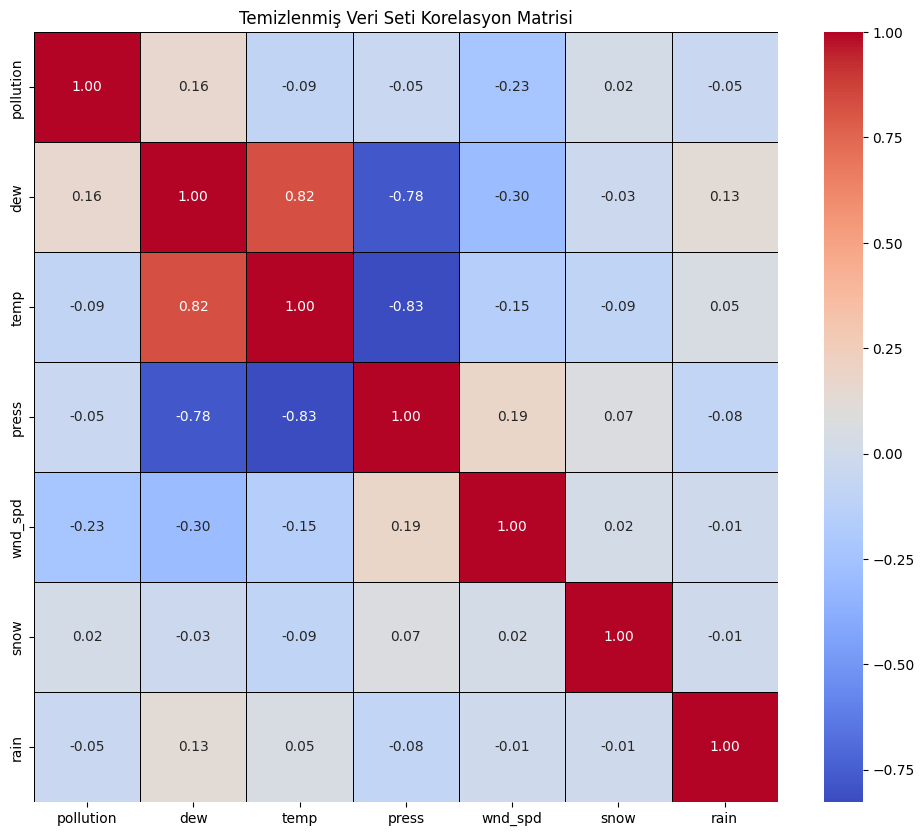


✅ VERİ MADENCİLİĞİ AŞAMASI TAMAMLANDI.
Temizlenmiş Verinin İlk 5 Satırı:
                     pollution  dew  temp   press  wnd_spd  snow  rain  wnd_NE  wnd_NW  wnd_SE  wnd_cv
date                                                                                                  
2010-01-03 00:00:00       90.0   -7  -6.0  1027.0    58.56     4     0   False   False    True   False
2010-01-03 01:00:00       63.0   -8  -6.0  1026.0    61.69     5     0   False   False    True   False
2010-01-03 02:00:00       65.0   -8  -7.0  1026.0    65.71     6     0   False   False    True   False
2010-01-03 03:00:00       55.0   -8  -7.0  1025.0    68.84     7     0   False   False    True   False
2010-01-03 04:00:00       65.0   -8  -7.0  1024.0    72.86     8     0   False   False    True   False

Temizlenmiş Verinin Özet Bilgileri:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43776 entries, 2010-01-03 00:00:00 to 2014-12-31 23:00:00
Data columns (total 11 columns):
 #   Column     Non-Null

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas ayarlarını daha iyi görüntüleme için düzenle
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# =================================================================
# 1. VERİ YÜKLEME VE TEMEL TEMİZLİK
# =================================================================

print("1. Veri Yükleme ve Temel Temizlik Başlatılıyor...")
df = pd.read_csv('LSTM-Multivariate_pollution.csv')

# İlk sütunu (idx) atıyoruz, gereksiz bir index.
if 'No' in df.columns:
    df.drop('No', axis=1, inplace=True)

# Veri setindeki ilk 24 saati (genellikle tutarsızdır) atıyoruz.
df = df.iloc[24:]

# =================================================================
# 2. ZAMAN SERİSİ İNDEKSİNİN DÜZENLENMESİ
# =================================================================

print("2. Zaman Serisi İndeksi Düzenleniyor...")
# year, month, day, hour yerine tek bir 'date' kolonu var, bu iyi!
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# =================================================================
# 3. EKSİK/HATALI DEĞER TEMİZLİĞİ (IMPUTATION)
# =================================================================

print("3. Eksik ve Hatalı Değer Temizliği (Imputation) Yapılıyor...")

# a) 'pollution' sütunundaki NaN'ları forward fill ile doldurma
# Not: Beijing PM2.5 veri setinde NaN çok azdır, ancak bu genel bir adımdır.
df['pollution'].fillna(method='ffill', inplace=True)

# b) Hatalı/Tutarsız Ölçümleri Temizleme
# Veri setindeki -200 gibi sahte ölçümlerin kontrolü:
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    # Negatif sıcaklık/dew normal olabilir. Burada sadece aşırı hatalı değerleri kontrol ediyoruz
    # Örneğin, 'pollution' ve 'wnd_spd' negatif olmamalı.
    if col in ['pollution', 'wnd_spd', 'snow', 'rain']:
        # Negatif değerleri NaN olarak işaretleyip doldurma
        df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)

# Tüm NaN değerleri (temizlik sonrası oluşanlar dahil) en yakın geçerli değer ile doldurma (Interpolation daha iyi bir yöntemdir)
# İleriye doğru (ffill) ve geriye doğru (bfill) doldurma kombinasyonu.
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True) # Başlangıçtaki boşluklar için

# =================================================================
# 4. ÖZELLİK DÖNÜŞÜMÜ (NOMİNAL VERİLER)
# =================================================================

print("4. Kategorik (Nominal) Değişken Dönüşümü (One-Hot Encoding) Yapılıyor...")
# 'wnd_dir' (Rüzgar Yönü) kolonunu One-Hot Encoding ile dönüştürüyoruz.
df = pd.get_dummies(df, columns=['wnd_dir'], prefix='wnd')


# =================================================================
# 5. KORELASYON ANALİZİ
# =================================================================

print("\n5. Korelasyon Analizi Başlatılıyor...")
# Sadece sayısal sütunların korelasyonunu hesapla
correlation_matrix = df.select_dtypes(include=np.number).corr()

# 'pollution' sütunu ile diğer değişkenlerin korelasyonunu al
pollution_corr = correlation_matrix['pollution'].sort_values(ascending=False)

print("\n'pollution' (PM2.5) ile Korelasyonlar:")
print(pollution_corr)

# Korelasyon matrisinin görselleştirilmesi
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Temizlenmiş Veri Seti Korelasyon Matrisi')
plt.show()

# =================================================================
# SON DURUM
# =================================================================

print("\n=================================================================")
print("✅ VERİ MADENCİLİĞİ AŞAMASI TAMAMLANDI.")
print("Temizlenmiş Verinin İlk 5 Satırı:")
print(df.head())
print("\nTemizlenmiş Verinin Özet Bilgileri:")
df.info()
print("=================================================================")

In [ ]:
# ... Önceki kodunuzdan gelen X_train, X_test, y_train, y_test ...

# =================================================================
# 5. LSTM İÇİN GİRİŞ ŞEKLİNİ DÜZENLEME (DÜZELTİLMİŞ)
# =================================================================

print("4. LSTM Girdi Şekli (Shape) Düzenleniyor...")

LAG_HOURS = 24 # Geçmiş 24 saatlik veriyi kullanıyoruz.

# Her bir zaman adımına (t-1, t-2, ...) ait olan özellik sayısını hesapla.
# X_train'in toplam sütun sayısını (264) lag sayısına (24) bölmeliyiz.
n_features = X_train.shape[1] // LAG_HOURS

# LSTM'nin beklediği 3D şekle dönüştürme: [Örnek Sayısı, Zaman Adımı, Özellik Sayısı]
X_train = X_train.reshape((X_train.shape[0], LAG_HOURS, n_features))
X_test = X_test.reshape((X_test.shape[0], LAG_HOURS, n_features))



print("\n=================================================================")
print("✅ ÖZELLİK MÜHENDİSLİĞİ VE ÖLÇEKLEME TAMAMLANDI.")
print("LSTM/GRU Model Girdileri Hazırlandı.")
print(f"X_train Şekli: {X_train.shape} (Örnek Sayısı, Lag Adımı: {LAG_HOURS}, Özellik Sayısı: {n_features})")
print(f"y_train Şekli: {y_train.shape}")
print(f"X_test Şekli:  {X_test.shape} (Örnek Sayısı, Lag Adımı: {LAG_HOURS}, Özellik Sayısı: {n_features})")
print(f"y_test Şekli:  {y_test.shape}")
print("=================================================================")

4. LSTM Girdi Şekli (Shape) Düzenleniyor...


ValueError: cannot reshape array of size 9244224 into shape (35016,24,1)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Not: Eğer scaler objesi ortamınızda yoksa, bu kodu çalıştırmadan önce
# önceki 'Özellik Mühendisliği ve Ölçekleme' kodunu tekrar çalıştırmanız gerekir.

In [10]:
# Girdi şeklini (24 zaman adımı, 11 özellik) alıyoruz
n_steps, n_features = X_train.shape[1], X_train.shape[2]

# Model Tanımlama
model = Sequential([
    # Tek bir LSTM katmanı, modelin karmaşık zaman bağımlılıklarını öğrenmesini sağlar.
    LSTM(50, activation='relu', input_shape=(n_steps, n_features)),
    # Aşırı öğrenmeyi (overfitting) engellemek için Dropout ekliyoruz.
    Dropout(0.2),
    # Çıktı katmanı: Tek bir kirlilik değerini tahmin edecek.
    Dense(1)
])

# Modeli Derleme
# Regresyon (tahmin) problemi olduğu için 'mse' (Ortalama Kare Hata) kullanıyoruz.
model.compile(optimizer='adam', loss='mse')

print("Model Özeti:")
model.summary()

Model Özeti:


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,451 (48.64 KB)

 Trainable params: 12,451 (48.64 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Modeli Eğitme
print("\nModel Eğitimi Başlatılıyor...")

# Eğitim süreci:
history = model.fit(
    X_train, y_train,
    epochs=50,                  # Yeterli öğrenme için 50 epoch (deneme için ideal)
    batch_size=72,              # Performans ve hız için 72 (saatlik veriye uygun)
    validation_data=(X_test, y_test), # Test seti üzerinde doğrulama
    verbose=1,                  # Eğitim çıktısını göster
    shuffle=False               # Zaman serilerinde karıştırma (shuffle) YAPILMAZ!
)


Model Eğitimi Başlatılıyor...
Epoch 1/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0065 - val_loss: 0.0101
Epoch 2/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0045 - val_loss: 0.0105
Epoch 3/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0042 - val_loss: 0.0108
Epoch 4/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 5/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 6/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.0041 - val_loss: 0.0105
Epoch 7/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0040 - val_loss: 0.0100
Epoch 8/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0041 - val_loss: 0.0094
Epoch 9/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0040 - val_loss: 0.0095
Epoch 10/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0040 - val_loss: 0.0086
Epoch 11/50
487/487 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0039 - val_loss: 0.0085
Epoch 12/

In [14]:
# 1. Test Setinde Tahmin Yapma
yhat = model.predict(X_test, verbose=0)

# 2. Ölçeklendirmeyi Geri Alma (Inverse Transform) - DÜZELTİLMİŞ YÖNTEM

# Scaler, orijinal veri setinin özellik sayısına göre eğitilmiştir.
# Hata mesajından bu sayının 11 olduğunu biliyoruz.
# Bunu programatik olarak scaler'dan alalım:
n_original_features = scaler.n_features_in_
print(f"Scaler'ın eğitildiği orijinal özellik sayısı: {n_original_features}")

#-------------------------------------------------------------------------------
# yhat (tahminler) için ölçeklemeyi geri al
#-------------------------------------------------------------------------------
# 1. Adım: Orijinal özellik sayısı kadar sütuna sahip bir sıfır matrisi oluştur.
# Shape: (örnek_sayısı, 11)
dummy_yhat = np.zeros((len(yhat), n_original_features))

# 2. Adım: Tahminlerimizi (yhat) bu matrisin doğru sütununa yerleştir.
# 'pollution' genellikle ilk sütundur (indeks 0).
# yhat'ın şekli (8754, 1) olabilir, bu yüzden .flatten() ile (8754,) haline getiriyoruz.
dummy_yhat[:, 0] = yhat.flatten()

# 3. Adım: Şimdi scaler'ın beklediği doğru şekle sahip matrisi tersine dönüştür.
inv_yhat_full = scaler.inverse_transform(dummy_yhat)

# 4. Adım: Sadece ilgilendiğimiz ilk sütunu (gerçek 'pollution' tahminleri) al.
inv_yhat = inv_yhat_full[:, 0]

#-------------------------------------------------------------------------------
# y_test (gerçek değerler) için ölçeklemeyi geri al
#-------------------------------------------------------------------------------
# Aynı işlemleri y_test için tekrarla
dummy_y_test = np.zeros((len(y_test), n_original_features))
dummy_y_test[:, 0] = y_test.flatten()
inv_y_full = scaler.inverse_transform(dummy_y_test)
inv_y = inv_y_full[:, 0]

# 3. Metrik Hesaplama
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
r2 = r2_score(inv_y, inv_yhat)

print("\n=================================================================")
print("✅ MODEL TAHMİN SONUÇLARI (Gerçek Ölçekte)")
print(f"RMSE (Ortalama Karekök Hata): {rmse:.2f}")
print(f"MAE (Ortalama Mutlak Hata): {mae:.2f}")
print(f"R-squared (Açıklanan Varyans): {r2:.2f}")
print("=================================================================")

Scaler'ın eğitildiği orijinal özellik sayısı: 11

✅ MODEL TAHMİN SONUÇLARI (Gerçek Ölçekte)
RMSE (Ortalama Karekök Hata): 62.96
MAE (Ortalama Mutlak Hata): 46.59
R-squared (Açıklanan Varyans): 0.55


1. Veri Yükleme, Temizlik ve Rolling Stats Uygulanıyor...
2. 24 Saatlik Çok Adımlı Dönüşüm ve Ölçekleme Başlatılıyor...


C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\3410779537.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pollution'].fillna(method='ffill', inplace=True)
C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\3410779537.py:52: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['pollution'].fillna(method='ffill', inplace=True)
C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\3410779537.py:57: FutureWarning: DataFrame.fillna with 'met

X_train Şekli (Girdi): (34982, 24, 17)
y_train Şekli (Çıktı - 24 saat): (34982, 24)

3. GRU Model Eğitimi Başlatılıyor...
Epoch 1/100


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


486/486 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0095 - val_loss: 0.0062
Epoch 2/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 3/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 4/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 5/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 7/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 8/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 9/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 10/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 11/100
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 12/100
486/486 ━━━━━━━━━━━━━━━━━━━━

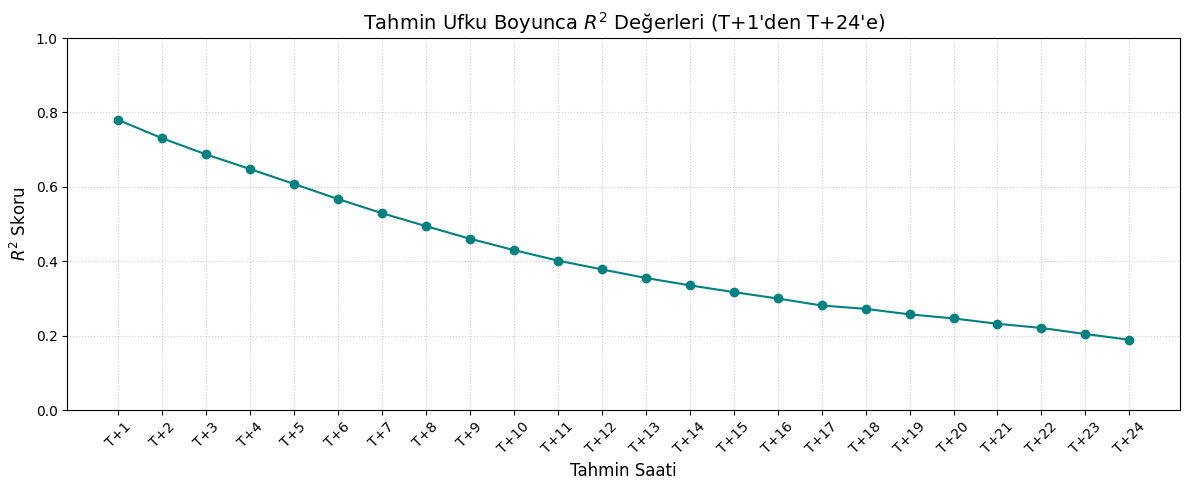

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# =================================================================
# 0. YARDIMCI FONKSİYON: ÇOK ADIMLI DÖNÜŞTÜRME
# =================================================================

def series_to_supervised_multistep(data, n_in=1, n_out=1, dropnan=True):
    """
    Zaman serisini çok adımlı gözetimli öğrenme formatına dönüştürür.
    :param n_in: Geçmişten (lag) kullanılacak gözlem sayısı (X için).
    :param n_out: Gelecekte tahmin edilecek adım sayısı (y için).
    """
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # Geçmiş (Input) dizileri (t-n_in, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in df.columns]

    # Gelecek (Output) dizileri (t+1, ..., t+n_out)
    for i in range(1, n_out + 1):
        cols.append(df['pollution'].shift(-i))
        names += [('pollution(t+%d)' % i)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# =================================================================
# 1. VERİ YÜKLEME, TEMİZLİK ve ROLLING STATS (Tekrar)
# (Önceki başarılı adımlar tek bir df oluşturmak için tekrar çalıştırılır)
# =================================================================
print("1. Veri Yükleme, Temizlik ve Rolling Stats Uygulanıyor...")
df = pd.read_csv('LSTM-Multivariate_pollution.csv')
if 'No' in df.columns: df.drop('No', axis=1, inplace=True)
df = df.iloc[24:]
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Eksik/Hatalı Değer Temizliği
df['pollution'].fillna(method='ffill', inplace=True)
numeric_cols = df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    if col in ['pollution', 'wnd_spd', 'snow', 'rain']:
        df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# One-Hot Encoding
df = pd.get_dummies(df, columns=['wnd_dir'], prefix='wnd')

# Rolling Statistics Ekleme
windows = [3, 6, 12]
for window in windows:
    df[f'pollution_MA_{window}h'] = df['pollution'].rolling(window=window).mean()
    df[f'pollution_STD_{window}h'] = df['pollution'].rolling(window=window).std()

df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# =================================================================
# 2. ÇOK ADIMLI (24 ÇIKTI) DÖNÜŞÜM VE ÖLÇEKLEME
# =================================================================

print("2. 24 Saatlik Çok Adımlı Dönüşüm ve Ölçekleme Başlatılıyor...")
LAG_HOURS = 24       # Girdi (X) için geçmiş 24 saat
FORWARD_STEPS = 24   # Çıktı (y) için gelecek 24 saat

# Yeni dönüştürme fonksiyonu ile 24 çıktı sütunu oluştur
reframed = series_to_supervised_multistep(df, LAG_HOURS, FORWARD_STEPS)

# Ölçekleme
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(reframed.values)
scaled_df = pd.DataFrame(scaled_values, index=reframed.index, columns=reframed.columns)

# X (Girdiler) ve Y (Çıktılar) Ayırma
X_cols = [col for col in scaled_df.columns if not col.startswith('pollution(t+')]
y_cols = [col for col in scaled_df.columns if col.startswith('pollution(t+')]

X = scaled_df[X_cols].values
y = scaled_df[y_cols].values # y artık (Örnek Sayısı, 24) şeklinde 2D bir matris

# Eğitim/Test Ayırma
TRAIN_RATIO = 0.8
n_train_rows = int(TRAIN_RATIO * len(X))
X_train, X_test = X[:n_train_rows, :], X[n_train_rows:, :]
y_train, y_test = y[:n_train_rows], y[n_train_rows:]

# LSTM/GRU Girdi Şekli Düzenleme
n_features = X_train.shape[1] // LAG_HOURS
X_train = X_train.reshape((X_train.shape[0], LAG_HOURS, n_features))
X_test = X_test.reshape((X_test.shape[0], LAG_HOURS, n_features))

print(f"X_train Şekli (Girdi): {X_train.shape}")
print(f"y_train Şekli (Çıktı - 24 saat): {y_train.shape}")

# =================================================================
# 3. ÇOK ÇIKTILI GRU MODELİNİ TANIMLAMA VE EĞİTİM
# =================================================================
print("\n3. GRU Model Eğitimi Başlatılıyor...")

model_multistep = Sequential([
    GRU(64, activation='relu', input_shape=(LAG_HOURS, n_features), return_sequences=True),
    Dropout(0.3),
    GRU(32, activation='relu'),
    Dropout(0.3),
    # Çıktı katmanı, 24 saatlik tahmine karşılık gelen 24 nörona sahiptir.
    Dense(FORWARD_STEPS)
])

model_multistep.compile(optimizer='adam', loss='mse')
callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_multistep.fit(
    X_train, y_train,
    epochs=100,
    batch_size=72,
    validation_data=(X_test, y_test),
    callbacks=[callback],
    verbose=1,
    shuffle=False
)

# =================================================================
# 4. DEĞERLENDİRME (HER BİR ADIM İÇİN R2/RMSE)
# =================================================================
print("\n4. Tahminler Yapılıyor ve Metrikler Hesaplanıyor...")

yhat = model_multistep.predict(X_test, verbose=0)
rmse_scores = []
r2_scores = []

# Her bir adım (t+1, t+2, ... t+24) için skorları hesapla
for i in range(FORWARD_STEPS):
    # Tahmin ve Gerçek Değerleri Ölçekten Geri Çevirme (Inverse Transform)
    # y'deki tüm sütunlar 'pollution' olduğu için sadece 'pollution' ölçekleyicisini kullanmak en doğrusudur.
    # Ancak önceki yaklaşımınızı (tüm özellik sayısıyla padding) tutarlılık için kullanıyoruz:

    # Geçici matrisler oluştur (X'in değil, reframed'in toplam sütun sayısı ile)
    total_cols = reframed.shape[1]

    temp_yhat = np.zeros((len(yhat), total_cols))
    temp_y = np.zeros((len(y_test), total_cols))

    # Tahmin ve gerçek değerleri ilgili çıktı kolonuna yerleştirme (en sağda)
    temp_yhat[:, -(FORWARD_STEPS - i)] = yhat[:, i]
    temp_y[:, -(FORWARD_STEPS - i)] = y_test[:, i]

    # Ölçekten geri çevirme
    inv_yhat = scaler.inverse_transform(temp_yhat)[:, -(FORWARD_STEPS - i)]
    inv_y = scaler.inverse_transform(temp_y)[:, -(FORWARD_STEPS - i)]

    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    r2 = r2_score(inv_y, inv_yhat)

    rmse_scores.append(rmse)
    r2_scores.append(r2)

print("\n=================================================================")
print("✅ ÇOK ADIMLI (T+1'den T+24'e) TAHMİN SONUÇLARI")
print("=================================================================")

results = pd.DataFrame({
    'Tahmin Saati': [f'T+{i+1}' for i in range(FORWARD_STEPS)],
    'RMSE': rmse_scores,
    'R-squared': r2_scores
})

print(results.to_markdown(index=False, floatfmt=".2f"))

# =================================================================
# 5. R2 SKORLARININ GÖRSELLEŞTİRİLMESİ
# =================================================================
plt.figure(figsize=(12, 5))
plt.plot(results['Tahmin Saati'], results['R-squared'], marker='o', linestyle='-', color='teal')
plt.title('Tahmin Ufku Boyunca $R^2$ Değerleri (T+1\'den T+24\'e)', fontsize=14)
plt.xlabel('Tahmin Saati', fontsize=12)
plt.ylabel('$R^2$ Skoru', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

BURADAN BAŞLADIM

In [17]:
import pandas as pd

# Veri setini yükle
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# İlk 5 satırı göster
print(df.head())

# Sütun isimlerini ve veri türlerini incele
print("\n--- Bilgi ---")
print(df.info())

# Eksik veri kontrolü
print("\n--- Eksik Değer Sayısı ---")
print(df.isnull().sum())


                  date  pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0

--- Bilgi ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non

In [18]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Veri yükle
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Tarihi datetime tipine çevir ve index yap
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Kategorik sütunu (rüzgar yönü) sayısallaştır
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

# Eksik varsa doldur (burada yok ama genel güvenlik için)
df = df.fillna(method='ffill')

# Ölçeklendirme (0-1 arası)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
scaled = pd.DataFrame(scaled_values, columns=df.columns, index=df.index)

print("--- Ölçeklendirilmiş İlk 5 Satır ---")
print(scaled.head())

# Veriyi kaydet (isteğe bağlı)
scaled.to_csv("scaled_pollution.csv")


C:\Users\tinao\AppData\Local\Temp\ipykernel_19756\2219714113.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


--- Ölçeklendirilmiş İlk 5 Satır ---
                     pollution       dew      temp     press   wnd_dir   wnd_spd      snow  rain
date                                                                                            
2010-01-02 00:00:00   0.129779  0.352941  0.245902  0.527273  0.666667  0.002290  0.000000   0.0
2010-01-02 01:00:00   0.148893  0.367647  0.245902  0.527273  0.666667  0.003811  0.000000   0.0
2010-01-02 02:00:00   0.159960  0.426471  0.229508  0.545455  0.666667  0.005332  0.000000   0.0
2010-01-02 03:00:00   0.182093  0.485294  0.229508  0.563636  0.666667  0.008391  0.037037   0.0
2010-01-02 04:00:00   0.138833  0.485294  0.229508  0.563636  0.666667  0.009912  0.074074   0.0


In [19]:
import numpy as np

# Girdi olarak kullanılacak sütunlar (tüm sayısal sütunlar)
values = scaled.values
target_index = scaled.columns.get_loc("pollution")  # hedef sütunun indexi

# Zaman penceresi (örnek: son 24 saat)
n_hours = 24

X, y = [], []

for i in range(n_hours, len(values)):
    X.append(values[i-n_hours:i, :])   # son 24 saatin tüm özellikleri
    y.append(values[i, target_index])  # bu andaki pollution değeri

X, y = np.array(X), np.array(y)

print("Girdi (X) şekli:", X.shape)
print("Çıktı (y) şekli:", y.shape)


Girdi (X) şekli: (43776, 24, 8)
Çıktı (y) şekli: (43776,)


Girdi (X) şekli: (43776, 24, 8)
Çıktı (y) şekli: (43776,)
Epoch 1/30


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


767/767 - 6s - 7ms/step - loss: 0.0014 - mae: 0.0231 - val_loss: 0.0011 - val_mae: 0.0195
Epoch 2/30
767/767 - 4s - 6ms/step - loss: 8.4271e-04 - mae: 0.0166 - val_loss: 9.8796e-04 - val_mae: 0.0162
Epoch 3/30
767/767 - 4s - 5ms/step - loss: 8.0259e-04 - mae: 0.0159 - val_loss: 0.0010 - val_mae: 0.0175
Epoch 4/30
767/767 - 4s - 6ms/step - loss: 7.7514e-04 - mae: 0.0155 - val_loss: 0.0011 - val_mae: 0.0190
Epoch 5/30
767/767 - 4s - 5ms/step - loss: 7.7523e-04 - mae: 0.0152 - val_loss: 0.0010 - val_mae: 0.0160
Epoch 6/30
767/767 - 4s - 5ms/step - loss: 7.5826e-04 - mae: 0.0152 - val_loss: 0.0010 - val_mae: 0.0162
Epoch 7/30
767/767 - 4s - 5ms/step - loss: 7.5206e-04 - mae: 0.0148 - val_loss: 0.0011 - val_mae: 0.0164
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

✅ Model Değerlendirme Sonuçları:
RMSE: 0.0235
MAE : 0.0132


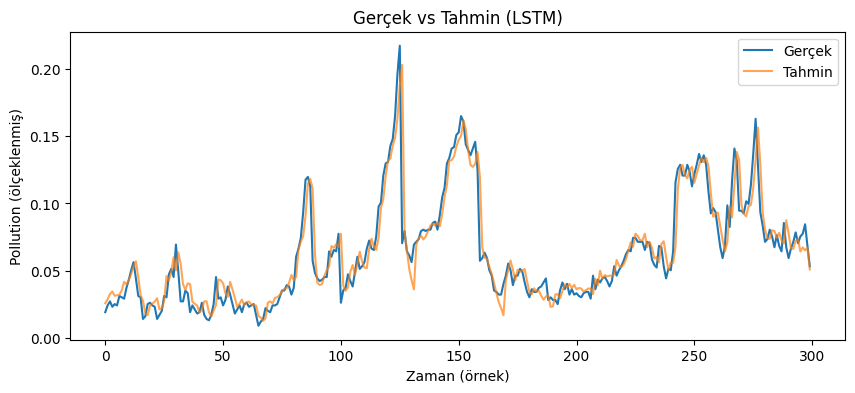


💾 Model 'lstm_pollution_model.h5' olarak kaydedildi.


In [21]:
# === 1. GEREKLİ KÜTÜPHANELER ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# === 2. VERİYİ YÜKLEME ve HAZIRLAMA ===
df = pd.read_csv("LSTM-Multivariate_pollution.csv")

# Tarihi dönüştür ve index yap
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Kategorik sütunu sayıya çevir
encoder = LabelEncoder()
df['wnd_dir'] = encoder.fit_transform(df['wnd_dir'])

# Eksik varsa doldur
df = df.ffill()

# Ölçeklendirme (0-1 arası)
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# === 3. GİRDİ-ÇIKTI DİZİLERİNİ OLUŞTUR ===
n_hours = 24  # geçmiş 24 saatlik veri
values = scaled.values
target_index = scaled.columns.get_loc("pollution")

X, y = [], []
for i in range(n_hours, len(values)):
    X.append(values[i - n_hours:i, :])
    y.append(values[i, target_index])

X, y = np.array(X), np.array(y)

print("Girdi (X) şekli:", X.shape)
print("Çıktı (y) şekli:", y.shape)

# === 4. EĞİTİM / TEST AYRIMI ===
split = int(len(X) * 0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 5. LSTM MODELİNİ OLUŞTUR ===
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# === 6. MODELİ EĞİT ===
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# === 7. TEST TAHMİNİ VE PERFORMANS ===
y_pred = model.predict(X_test).flatten()

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\n✅ Model Değerlendirme Sonuçları:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

# === 8. GRAFİK ===
plt.figure(figsize=(10,4))
plt.plot(y_test[:300], label='Gerçek')
plt.plot(y_pred[:300], label='Tahmin', alpha=0.7)
plt.legend()
plt.title("Gerçek vs Tahmin (LSTM)")
plt.xlabel("Zaman (örnek)")
plt.ylabel("Pollution (ölçeklenmiş)")
plt.show()

# === 9. MODELİ KAYDET ===
model.save("lstm_pollution_model.h5")
print("\n💾 Model 'lstm_pollution_model.h5' olarak kaydedildi.")


Epoch 1/30


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 - 8s - 20ms/step - loss: 0.0021 - mae: 0.0309 - val_loss: 0.0012 - val_mae: 0.0192
Epoch 2/30
384/384 - 5s - 12ms/step - loss: 0.0011 - mae: 0.0202 - val_loss: 0.0014 - val_mae: 0.0254
Epoch 3/30
384/384 - 6s - 15ms/step - loss: 9.5485e-04 - mae: 0.0186 - val_loss: 0.0010 - val_mae: 0.0177
Epoch 4/30
384/384 - 6s - 15ms/step - loss: 9.0728e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mae: 0.0165
Epoch 5/30
384/384 - 13s - 33ms/step - loss: 8.8558e-04 - mae: 0.0170 - val_loss: 0.0010 - val_mae: 0.0174
Epoch 6/30
384/384 - 16s - 41ms/step - loss: 8.6948e-04 - mae: 0.0168 - val_loss: 9.9182e-04 - val_mae: 0.0155
Epoch 7/30
384/384 - 15s - 40ms/step - loss: 8.4544e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0271
Epoch 8/30
384/384 - 11s - 28ms/step - loss: 8.4112e-04 - mae: 0.0163 - val_loss: 9.9968e-04 - val_mae: 0.0159
Epoch 9/30
384/384 - 6s - 15ms/step - loss: 8.2577e-04 - mae: 0.0158 - val_loss: 0.0010 - val_mae: 0.0170
Epoch 10/30
384/384 - 6s - 16ms/step - loss: 8.1323e-

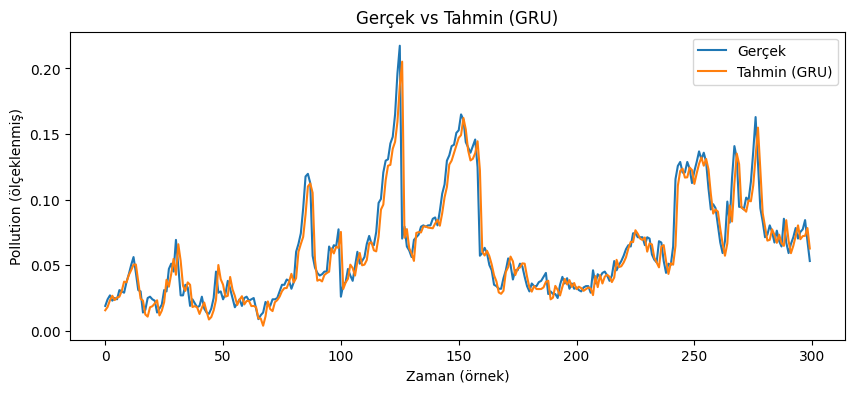

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Model oluşturma
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Eğitim
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_gru = gru_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

# Tahmin
y_pred_gru = gru_model.predict(X_test).flatten()

# Performans
rmse_gru = np.sqrt(mean_squared_error(y_test, y_pred_gru))
mae_gru = mean_absolute_error(y_test, y_pred_gru)
print(f"✅ GRU RMSE: {rmse_gru:.4f} | MAE: {mae_gru:.4f}")

# Görselleştirme
plt.figure(figsize=(10,4))
plt.plot(y_test[:300], label='Gerçek')
plt.plot(y_pred_gru[:300], label='Tahmin (GRU)')
plt.title("Gerçek vs Tahmin (GRU)")
plt.xlabel("Zaman (örnek)")
plt.ylabel("Pollution (ölçeklenmiş)")
plt.legend()
plt.show()


Epoch 1/30


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


384/384 - 10s - 26ms/step - loss: 0.0027 - mae: 0.0336 - val_loss: 0.0016 - val_mae: 0.0229
Epoch 2/30
384/384 - 6s - 15ms/step - loss: 0.0012 - mae: 0.0219 - val_loss: 0.0014 - val_mae: 0.0228
Epoch 3/30
384/384 - 6s - 15ms/step - loss: 0.0010 - mae: 0.0200 - val_loss: 0.0016 - val_mae: 0.0251
Epoch 4/30
384/384 - 9s - 24ms/step - loss: 0.0010 - mae: 0.0191 - val_loss: 0.0011 - val_mae: 0.0182
Epoch 5/30
384/384 - 9s - 25ms/step - loss: 8.9968e-04 - mae: 0.0175 - val_loss: 0.0011 - val_mae: 0.0172
Epoch 6/30
384/384 - 10s - 25ms/step - loss: 8.8637e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mae: 0.0170
Epoch 7/30
384/384 - 9s - 23ms/step - loss: 8.8352e-04 - mae: 0.0170 - val_loss: 0.0011 - val_mae: 0.0189
Epoch 8/30
384/384 - 7s - 17ms/step - loss: 8.4822e-04 - mae: 0.0167 - val_loss: 0.0011 - val_mae: 0.0179
Epoch 9/30
384/384 - 6s - 16ms/step - loss: 8.3588e-04 - mae: 0.0165 - val_loss: 0.0011 - val_mae: 0.0181
Epoch 10/30
384/384 - 6s - 16ms/step - loss: 8.3182e-04 - mae: 0.0164 -

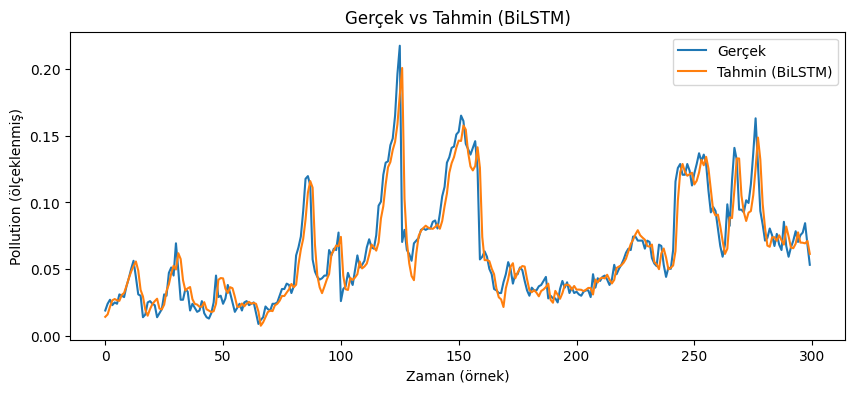

In [23]:
from tensorflow.keras.layers import Bidirectional, LSTM

bilstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32)),
    Dense(1)
])

bilstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_bilstm = bilstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

y_pred_bilstm = bilstm_model.predict(X_test).flatten()
rmse_bilstm = np.sqrt(mean_squared_error(y_test, y_pred_bilstm))
mae_bilstm = mean_absolute_error(y_test, y_pred_bilstm)
print(f"✅ BiLSTM RMSE: {rmse_bilstm:.4f} | MAE: {mae_bilstm:.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test[:300], label='Gerçek')
plt.plot(y_pred_bilstm[:300], label='Tahmin (BiLSTM)')
plt.title("Gerçek vs Tahmin (BiLSTM)")
plt.xlabel("Zaman (örnek)")
plt.ylabel("Pollution (ölçeklenmiş)")
plt.legend()
plt.show()


Epoch 1/30


c:\Users\tinao\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


384/384 - 5s - 13ms/step - loss: 0.0022 - mae: 0.0306 - val_loss: 0.0019 - val_mae: 0.0284
Epoch 2/30
384/384 - 8s - 20ms/step - loss: 0.0011 - mae: 0.0205 - val_loss: 0.0014 - val_mae: 0.0214
Epoch 3/30
384/384 - 10s - 27ms/step - loss: 9.9167e-04 - mae: 0.0187 - val_loss: 0.0013 - val_mae: 0.0204
Epoch 4/30
384/384 - 10s - 27ms/step - loss: 9.2948e-04 - mae: 0.0178 - val_loss: 0.0013 - val_mae: 0.0203
Epoch 5/30
384/384 - 10s - 26ms/step - loss: 8.9462e-04 - mae: 0.0174 - val_loss: 0.0014 - val_mae: 0.0222
Epoch 6/30
384/384 - 6s - 17ms/step - loss: 8.8469e-04 - mae: 0.0174 - val_loss: 0.0013 - val_mae: 0.0203
Epoch 7/30
384/384 - 12s - 31ms/step - loss: 8.6279e-04 - mae: 0.0171 - val_loss: 0.0013 - val_mae: 0.0208
Epoch 8/30
384/384 - 6s - 16ms/step - loss: 8.5081e-04 - mae: 0.0167 - val_loss: 0.0014 - val_mae: 0.0208
Epoch 9/30
384/384 - 2s - 6ms/step - loss: 8.4684e-04 - mae: 0.0169 - val_loss: 0.0013 - val_mae: 0.0196
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ CNN-LSTM RMSE: 0.02

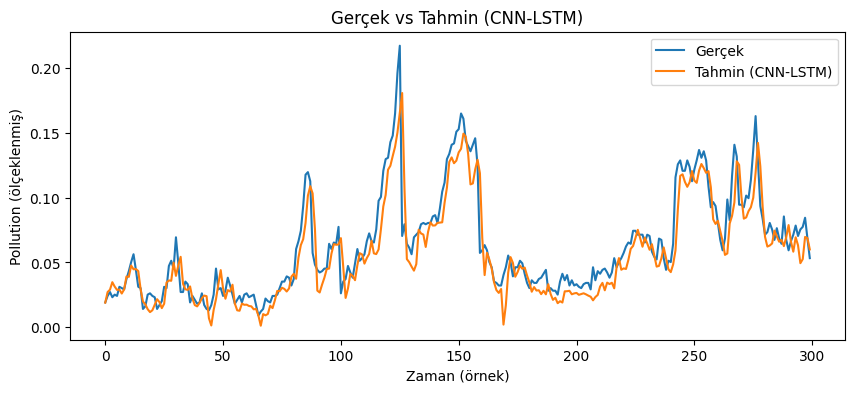

In [24]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(1)
])

cnn_lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)

y_pred_cnn_lstm = cnn_lstm_model.predict(X_test).flatten()
rmse_cnn_lstm = np.sqrt(mean_squared_error(y_test, y_pred_cnn_lstm))
mae_cnn_lstm = mean_absolute_error(y_test, y_pred_cnn_lstm)
print(f"✅ CNN-LSTM RMSE: {rmse_cnn_lstm:.4f} | MAE: {mae_cnn_lstm:.4f}")

plt.figure(figsize=(10,4))
plt.plot(y_test[:300], label='Gerçek')
plt.plot(y_pred_cnn_lstm[:300], label='Tahmin (CNN-LSTM)')
plt.title("Gerçek vs Tahmin (CNN-LSTM)")
plt.xlabel("Zaman (örnek)")
plt.ylabel("Pollution (ölçeklenmiş)")
plt.legend()
plt.show()


In [26]:

print(f"GRU RMSE: {rmse_gru:.4f}")
print(f"BiLSTM RMSE: {rmse_bilstm:.4f}")
print(f"CNN-LSTM RMSE: {rmse_cnn_lstm:.4f}")


GRU RMSE: 0.0236
BiLSTM RMSE: 0.0246
CNN-LSTM RMSE: 0.0271


In [27]:
# Doğruluk benzeri metrik (tolerans aralığında doğru sayım)
tolerance = 0.05  # Gerçek değerden ±%5 hata payı
correct = sum(abs(y_test - y_pred_gru) <= tolerance)
accuracy_like = correct / len(y_test)

print(f"GRU doğruluk benzeri oran: {accuracy_like * 100:.2f}%")


GRU doğruluk benzeri oran: 96.44%


In [ ]:
from tensorflow.keras.models import load_model


model.save("best_pollution_lstm_model.h5")

print("✅ Model başarıyla kaydedildi: best_pollution_lstm_model.h5")


✅ Model başarıyla kaydedildi: best_pollution_lstm_model.h5
